In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.utils import resample
from wordcloud import WordCloud
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import string
import tensorflow as tf

sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [2]:
# Loading the data.
data  =  pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

In [3]:
# Look at the rop few rows of the data.
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Check if there are any missing values.
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Text(0.5, 1.0, 'Count of toxic and non-toxic comments in the dataset')

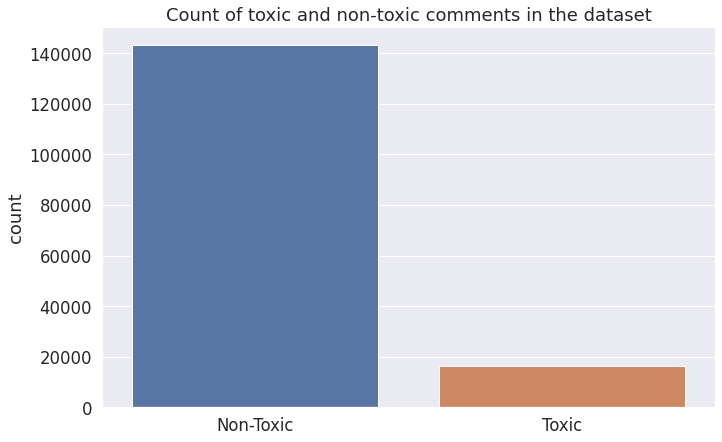

In [5]:
# Plotting the count of toxic vs. non-toxic comments in the dataset.
def is_toxic(r):
    if r.toxic == 1:
        return True
    elif r.severe_toxic == 1:
        return True
    elif r.obscene == 1:
        return True
    elif r.threat == 1:
        return True
    elif r.insult == 1:
        return True
    elif r.identity_hate == 1:
        return True
    return False

is_toxic = data.apply(lambda r: is_toxic(r), axis=1)

plt.figure(figsize=(11,7))
is_toxic.replace({False: 'Non-Toxic', True: 'Toxic'}, inplace=True)
sns.countplot(x=is_toxic)
plt.title("Count of toxic and non-toxic comments in the dataset")

#### As can be seen above, the dataset is highly imbalanced.

In [6]:
# Storing all possible classes/labels.
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [7]:
# Computing percentage of each label in the data.
N = len(data)
label_pct_map = dict()
for label in labels:
    label_pct_map[label] = data[label].sum() / N

[Text(0.5, 1.0, 'Distribution of different classes in the dataset: Maximum comments are toxic.'),
 Text(0.5, 0, 'Toxicity Class'),
 Text(0, 0.5, 'Percentage')]

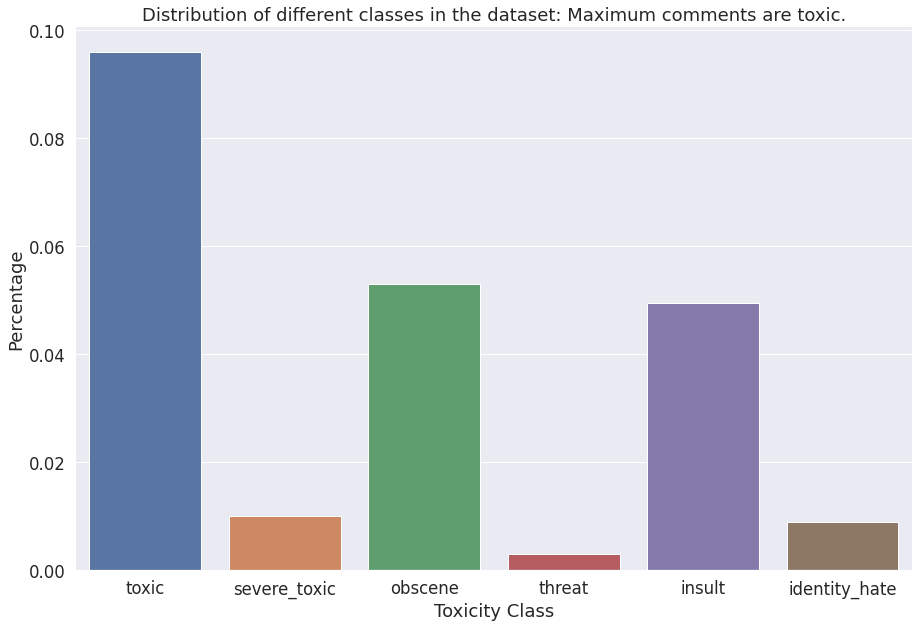

In [8]:
# Plotting percentage of each class present in the dataset.
plt.figure(figsize=(15,10))
ax = sns.barplot(x=list(label_pct_map.keys()), y=list(label_pct_map.values()))
ax.set(title="Distribution of different classes in the dataset: Maximum comments are toxic.",
       xlabel="Toxicity Class",
       ylabel="Percentage")

[Text(0.5, 1.0, 'Distribution of length of comments is right-skewed'),
 Text(0.5, 0, 'Length of Comment')]

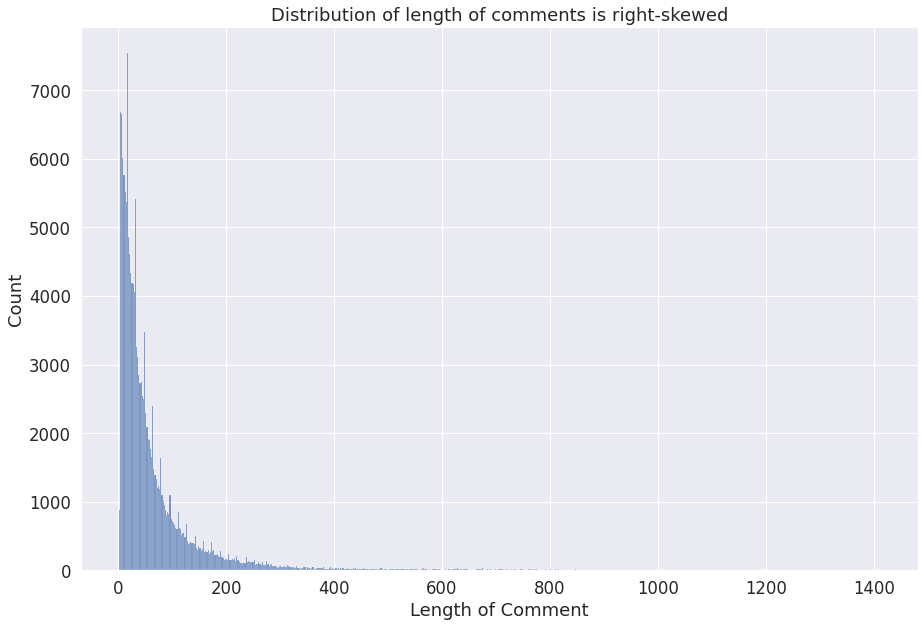

In [9]:
# Plotting distribution of comment length.
data['comment_length'] = data.apply(lambda r: len(r.comment_text.split()), axis=1)
plt.figure(figsize=(15,10))
ax = sns.histplot(data, x="comment_length")
ax.set(title="Distribution of length of comments is right-skewed", xlabel="Length of Comment")

#### As can be seen above, the distribution of comment length is right-skewed.

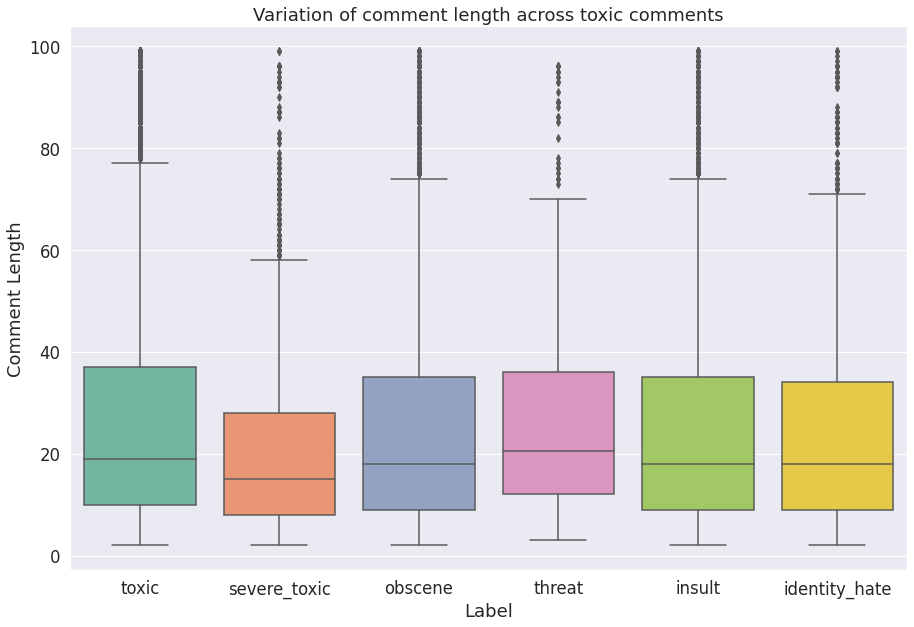

In [10]:
# Visualize the variation of comment length across various classes.
data["label"] = ""
tbls = []
for label in labels:
    df = data[data[label] == 1].copy()
    df["label"] = label
    df.drop('comment_text', inplace=True, axis=1)
    df.drop('id', inplace=True, axis=1)
    tbls.append(df)
df = pd.concat(tbls, axis=0)
df.reset_index(drop=True, inplace=True)

data.drop('comment_length', inplace=True, axis=1)
data.drop('label', inplace=True, axis=1)

plt.figure(figsize=(15,10))
ax = sns.boxplot(x="label", y="comment_length", palette="Set2", data=df[df['comment_length'] < 100])
ax.set(title="Variation of comment length across toxic comments", xlabel="Label", ylabel="Comment Length")

del df

#### The severe toxic comments seem to be relatively shorter compared to others. Other than that, there is no specific variation in length of comments based on toxicity.

#### Also, for the above plot to materialize, the comments had to be trimmed to size < 100. There are many outliers in the dataset as can be inferred from the right-skewed plot above. There are a handful of comments only of length > 400.

In [11]:
def clean_comment(comment):
    """
    Clean comments in the dataset.
    
    :param comment: comment string that is present in the input file.
    :type  comment: str
    :return: string that has been cleaned using Wordnet Lemmatizer, etc. 
    :rtype: str
    """
    
    comment = comment.lower()  # convert to lowercase
    comment = re.sub(r'^https?:\/\/.*[\s]*', '', comment)  # remove links
    words = nltk.tokenize.word_tokenize(comment)
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    final_tokens = []
    for w in words:
        w = "".join(["" if c in string.punctuation else c for c in w])  # remove punctutation
        if w != "" and w not in stop_words:  # process only non stopwords
            final_tokens.append(lemmatizer.lemmatize(w))  # using WordNet for lemmatizing
    cleaned_comment = " ".join(final_tokens)
    return cleaned_comment

In [12]:
# Clean all the comments in the dataset.
data['comment'] = data.apply(lambda r: clean_comment(r.comment_text), axis=1)
data.drop('comment_text', inplace=True, axis=1)

In [13]:
# Removing any empty comments.
data = data[data['comment'] != ""]

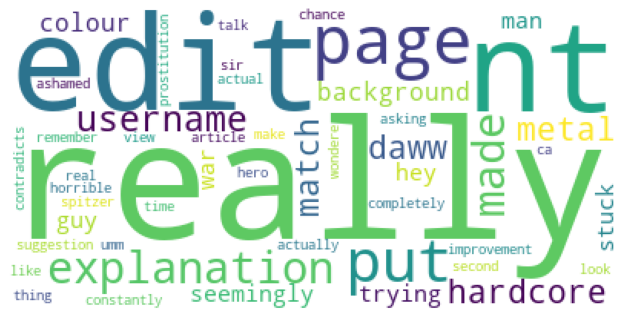

In [14]:
# Plotting word cloud of all comments in the dataset.
wordcloud = WordCloud(stopwords=nltk.corpus.stopwords.words('english'), 
                      max_words=50, background_color="white").generate(str(data.comment))
plt.figure(figsize=(11,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

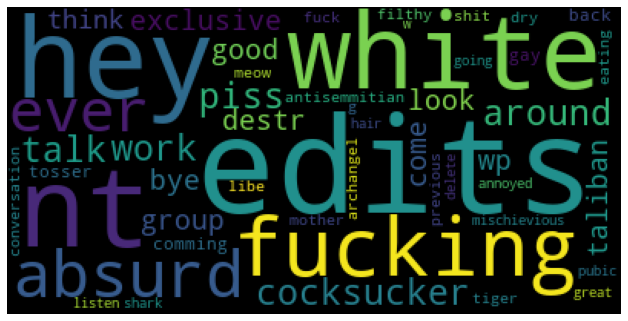

In [15]:
# Plotting word cloud of all toxic comments in the dataset.
toxic_text = str(data[(data['identity_hate']==1) | 
                      (data['insult']==1) | 
                      (data['obscene']==1) | 
                      (data['severe_toxic']==1) | 
                      (data['threat']==1) | 
                      (data['toxic']==1)].comment)
wordcloud = WordCloud(stopwords=nltk.corpus.stopwords.words('english'), 
                      max_words=50, background_color="black").generate(toxic_text)
plt.figure(figsize=(11,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

* #### As we can see, the toxic comments have a lot of abusive words present.
* #### Interesting Observation: The word edit/edits is present in both comments and toxic comments. This word has no sentiment as such attached to it. Could this be specific to the dataset and its comments?

<AxesSubplot:>

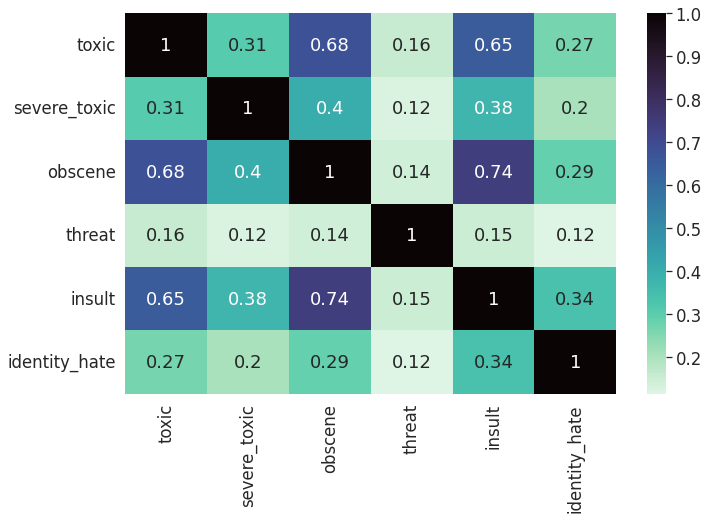

In [16]:
# Plotting the correlation matrix between various labels.
plt.figure(figsize=(11, 7))
sns.heatmap(data.corr(), annot=True, cmap="mako_r")

#### I believe it will be more difficult to classify labels that are highly correlated with another label/category since it will have similar words/text.

#### For example, **insult** has significant (though not very high) correlation with **toxic** and **obscence** comments, therefore, it might not be easier to classify.